In [1]:
using Revise, Statistics, Distributions, LaTeXStrings
using Formatting
using CairoMakie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%10.$(N)f",x)

set_theme!(Theme(
    fontsize = 20,
    palette = ( color = Dark2_8,),
    Axis = (
        backgroundcolor = :transparent,
        xtickcolor = nord[5], ytickcolor = nord[5],
        xgridcolor = nord[3], ygridcolor = nord[3],
        xlabelcolor = nord[5], ylabelcolor = nord[5],
        xticklabelcolor = nord[5], yticklabelcolor = nord[5],
        topspinecolor = nord[5], bottomspinecolor = nord[5],
        leftspinecolor = nord[5], rightspinecolor = nord[5],
        titlecolor = nord[5],
    ),
    Legend = (
        bgcolor = :transparent,
        labelcolor = nord[5], titlecolor = nord[5],
        framevisible = false, margin=(0,0,0,0)
    )
))

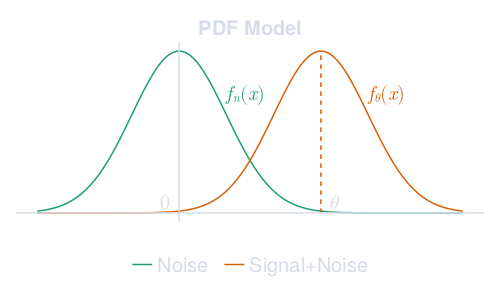

In [2]:
θ = 15; σ = 5;
xs = range(-15,30,200)
fn = Normal(0, σ)
fs = Normal(θ, σ)

F = Figure(backgroundcolor=:transparent, resolution=(500,300))
ax = Axis(F[1,1], title="PDF Model")
# Plots
l1 = lines!(xs, pdf.(fn, xs));
text!(5, pdf(fn,5)*1.1, text=L"f_n(x)", color=l1.color)
text!(-1, 0, text=L"0", align = (:right, :bottom), color=nord[5])

l2 = lines!(xs, pdf.(fs, xs))
lines!([θ,θ],[0, pdf(fs,θ)], color=l2.color, linestyle=:dash)
text!(θ+1, 0, text=L"\theta", align=(:left, :bottom), color=nord[5])
text!(5+θ, pdf(fs,5+θ)*1.1, text=L"f_\theta(x)", color=l2.color)
# Axis lines
yline = vlines!(ax, 0, color = nord[5]); xline = hlines!(ax, 0, color = nord[5])
hidespines!(ax); hidedecorations!(ax)
Legend(F[2,1], [l1, l2], ["Noise", "Signal+Noise"], orientation=:horizontal)
save("PDFs.pdf", F)
F

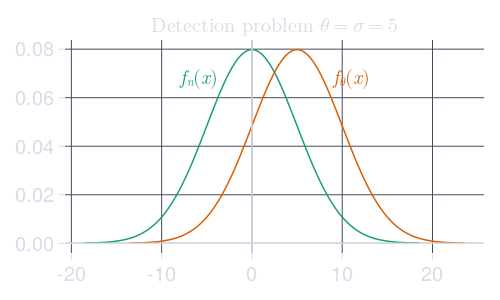

In [3]:
θ = σ = 5
fn = Normal(0,σ); fs = Normal(θ,σ)
F = Figure(backgroundcolor=:transparent, resolution=(500, 300))
ax = Axis(F[1,1], title=L"\text{Detection problem } \theta=\sigma=5")
l1 = lines!(fn); l2 = lines!(fs)
yline = vlines!(0, color = nord[5]); xline = hlines!(0, color = nord[5])
text!(-8, pdf(fn,4)*1.1, text=L"f_n(x)", color=l1.color)
text!(4+θ, pdf(fs,4+θ)*1.1, text=L"f_\theta(x)", color=l2.color)
hidespines!(ax)
save("b.pdf", F)
F

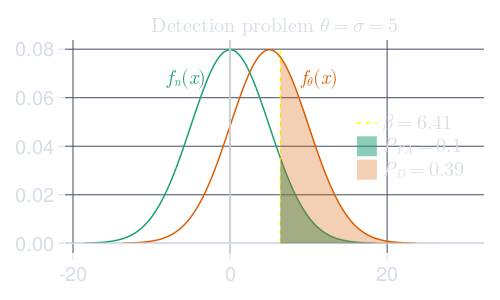

In [4]:
β = cquantile(fn, 0.1)
P_fa = ccdf(fn, β)
P_d  = ccdf(fs, β)
lines!([β, β], [0.0,pdf(fn, 0)], linestyle=:dash, color=:yellow,label=L"β=%$(printx(β,2))")
xs2 = β:0.1:xs[end]
b1 = band!(xs2, zeros(size(xs2)), pdf.(fn,xs2), color=(l1.color, 0.5), transparency=true, label=L"P_{FA}=%$(printx(P_fa,1))")
b2 = band!(xs2, zeros(size(xs2)), pdf.(fs,xs2), color=(l2.color, 0.3), transparency=true, label=L"P_{D}=%$(printx(P_d,2))")
axislegend(ax, position=:rc)
save("c.pdf", F)
F

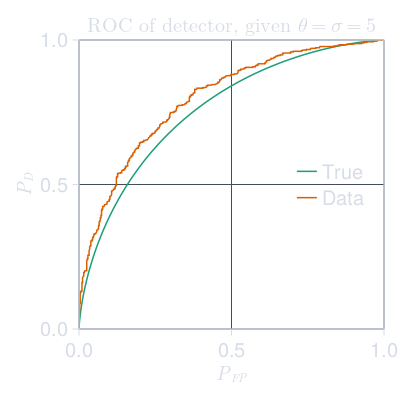

In [176]:
θ = σ = 5
nData = 1000
s = θ * (randn(nData,1) .>= 0); # True data
x = s + σ * randn(size(s));

fn, fs = Normal(0, σ), Normal(θ, σ)

# Theoretical ROC
βs = 20:-0.01:-20
TPR_true,TFP_true = ccdf.(fs,βs), ccdf.(fn,βs)

detector = map(β -> β .< x, βs)
TPR_data = map(result -> mean(result[s .> 0.5θ]), detector)
TFP_data = map(result -> mean(result[s .< 0.5θ]), detector);

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC of detector, given }\theta=\sigma=5", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")
lines!(TFP_data, TPR_data, label="Data")
axislegend(ax, position=:rc)
save("d.pdf", F)
F

In [178]:
nData = 1000
βs = 20:-0.01:-20

function roc_realization()
    s = θ * (randn(nData,1) .>= 0); # True data
    x = s + σ * randn(size(s));
    detector = map(β -> β .< x, βs)
    TPR_data = map(result -> mean(result[s .> 0.5θ]), detector)
    TFP_data = map(result -> mean(result[s .< 0.5θ]), detector);
    return TPR_data, TFP_data
end


roc_realization (generic function with 1 method)

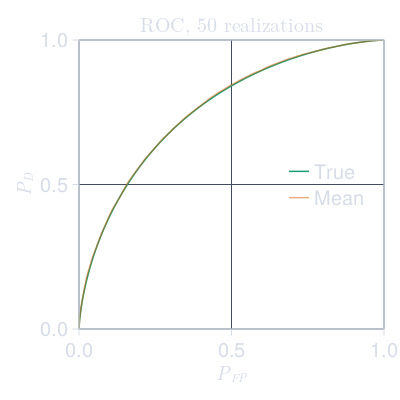

In [183]:
many_runs = [ roc_realization() for _ in 1:50 ]

TPR_many = mapreduce(run ->run[1], hcat, many_runs)
TFP_many = mapreduce(run -> run[2], hcat, many_runs)  # -> β × run

TPR_mean = mean(TPR_many, dims=2); TFP_mean = mean(TFP_many, dims=2);

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC, 50 realizations}", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")
lines!(TFP_mean[:], TPR_mean[:], label="Mean", color = (Dark2_8[2], 0.5))
axislegend(ax, position=:rc)
save("d2.pdf", F)
F

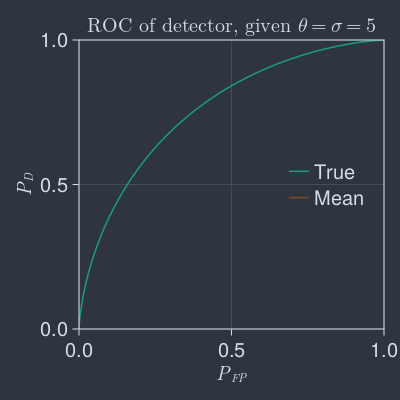

In [184]:
function step(frame=1)
    many_runs = [ roc_realization() for _ in 1:frame ]

    TPR_many = mapreduce(run ->run[1], hcat, many_runs)   # All TPR [β × run]
    TFP_many = mapreduce(run -> run[2], hcat, many_runs)  # All TFP [β × run]

    return Point2f.(mean(TFP_many, dims=2)[:],mean(TPR_many, dims=2)[:]);
end

F = Figure(backgroundcolor=nord[1],resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC of detector, given }\theta=\sigma=5", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")

points = Observable(Point2f[])

mean_line = lines!(points, label="Mean", color = (Dark2_8[2], 0.5))
axislegend(ax, position=:rc)

N_frames = 75

record(F, "test.mp4", 1:N_frames, framerate=7) do frame
    points[] = step(frame)
    ax.title = L"\text{ROC, %$(frame)/%$(N_frames) realizations}"
    notify(points)
end

F

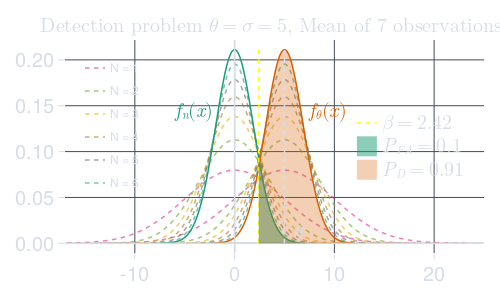

In [185]:
function mean_multi_cfar(pdf_noise, pdf_signal, N)
    return Normal(0,scale(pdf_noise)/sqrt(N)), 
           Normal(location(pdf_signal), scale(pdf_signal)/sqrt(N))
end

N = 7
multi_fn, multi_fs = mean_multi_cfar(fn, fs, N)
β = cquantile(multi_fn, 0.1)
P_fa = ccdf(multi_fn, β)
P_d  = ccdf(multi_fs, β)

F = Figure(backgroundcolor=:transparent, resolution=(500, 300))
ax = Axis(F[1,1], title=L"\text{Detection problem } \theta=\sigma=5,\text{ Mean of } %$(N)\text{ observations }")
sub_ls = Lines[]
sub_la = String[]
for n in 1:1:(N-1)
    sub_multi_fn, sub_multi_fs = mean_multi_cfar(fn,fs,n)
    lines!(sub_multi_fn, color=(Dark2_8[(n+2) % 8 + 1], 0.6), linestyle=:dash)
    sub_line = lines!(sub_multi_fs, color=(Dark2_8[(n+2) % 8 + 1], 0.6), linestyle=:dash)
    push!(sub_ls, sub_line)
    push!(sub_la, "N = $n")
end
l1 = lines!(multi_fn); l2 = lines!(multi_fs)
yline = vlines!(0, color = nord[5]); xline = hlines!(0, color = nord[5])
text!(-6,  pdf(multi_fn,-2)*1.1, text=L"f_n(x)", color=l1.color)
text!(2.5+θ, pdf(multi_fs,2+θ)*1.1, text=L"f_\theta(x)", color=l2.color)
hidespines!(ax)
xlims!(-17, 25)

lines!([β, β], [0.0,pdf(multi_fn, 0)], linestyle=:dash, color=:yellow,label=L"β=%$(printx(β,2))")
xs2 = β:0.1:xs[end]
b1 = band!(xs2, zeros(size(xs2)), pdf.(multi_fn,xs2), color=(l1.color, 0.5), transparency=true, label=L"P_{FA}=%$(printx(P_fa,1))")
b2 = band!(xs2, zeros(size(xs2)), pdf.(multi_fs,xs2), color=(l2.color, 0.3), transparency=true, label=L"P_{D}=%$(printx(P_d,2))")
axislegend(ax, position=:rc)
T = axislegend(ax, sub_ls, sub_la, position=:lt, labelsize=12)

lines!([θ,θ],[0, pdf(multi_fs,θ)], color=nord[5], linestyle=:dash)
text!(θ+1, 0, text=L"\theta", align=(:left, :bottom), color=nord[5])

save("f.pdf", F)
F

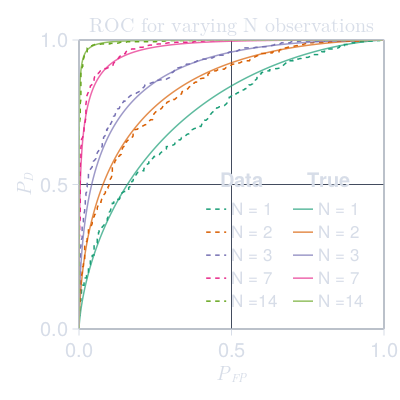

In [188]:
θ = σ = 5
fn = Normal(0, σ); fs = Normal(θ, σ)
nData = 1000
signal = θ*(randn(nData, 1) .>= 0)

function make_observations(signal, noise_pdf, N)
    S = repeat(signal, 1, N)
    X = S .+ rand(noise_pdf, size(S))
    return X
end

function mean_detector(observations, threshold)
    return mean(observations, dims=2) .>= threshold
end

X = make_observations(signal, multi_fn, 4)
mean_detector(X, 0.2)

βs = range(20,-20, 1000)

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC for varying N observations}", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)

data_lines = Vector{Lines}(undef, 5)
true_lines = Vector{Lines}(undef, 5)
N = [1,2,3,7,14]
for (i,n) in enumerate(N)
    noise_pdf, signal_pdf = mean_multi_cfar(fn, fs, n)

    X = make_observations(signal, fn, n)

    detector = map(β -> mean_detector(X, β), βs)

    TPR_data = map(result -> mean(result[signal .> 0.5θ]), detector)
    TFP_data = map(result -> mean(result[signal .< 0.5θ]), detector);
    
    l1 = lines!(TFP_data, TPR_data, linestyle=:dash)

    TPR_true,TFP_true = ccdf.(signal_pdf,βs), ccdf.(noise_pdf,βs)
    l2 = lines!(TFP_true, TPR_true, color=(l1.color, 0.7))
    data_lines[i] = l1
    true_lines[i] = l2
end

axislegend(ax, 
    [data_lines, true_lines], 
    [["N =$(sprintf1("%2d", n))" for n=N] for i = 1:2],
    ["Data", "True"],
    position=:rb, labelsize=17, nbanks=5,
    orientation = :horizontal
)
save("g.pdf", F)
F

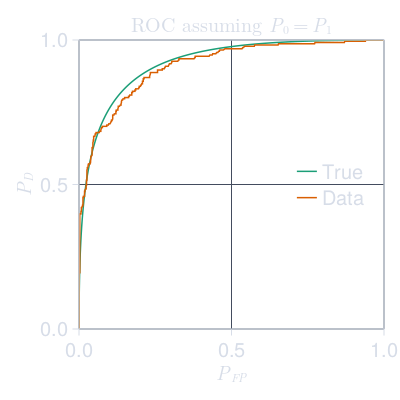

In [190]:
θ = 5
σ = 2.5
fn = Normal(0, σ); fs = Normal(θ, σ)
nData = 1000
signal = θ*(randn(nData, 1) .>= 1/sqrt(2)) # = ccdf(Normal(0,1), 1/sqrt(2)) ~ 24%
x = signal + rand(fn, size(signal))

# Theoretical ROC
βs = 20:-0.01:-20
TPR_true,TFP_true = ccdf.(fs,βs), ccdf.(fn,βs)

detector = map(β -> β .< x, βs)
TPR_data = map(result -> mean(result[signal .> 0.5θ]), detector)
TFP_data = map(result -> mean(result[signal .< 0.5θ]), detector);

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC assuming } P_0 = P_1", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")
lines!(TFP_data, TPR_data, label="Data")
axislegend(ax, position=:rc)
save("h.pdf", F)
F